In [18]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

def readRGB(filename: str):
    # 读入一个 RGB 图像
    blue, green, red = cv2.split(
        cv2.imread(filename)
    )
    return cv2.merge((red, green, blue))

def readGRAY(filename: str):
    # 读入一个单通道灰度图
    return cv2.cvtColor(
        readRGB(filename),
        cv2.COLOR_BGR2GRAY
    )

def show_gray(pic):
    plt.imshow(pic, cmap = 'gray')

In [19]:
def cal(pic, T):
    row, col = pic.shape
    high = low = 0
    n_high = n_low = 0
    # 遍历图像，大于阈值者，计算像素值和、计数值增一
    for i in range (row):
        for j in range (col):
            if pic[i, j] > T:
                high += pic[i, j]
                n_high += 1
            else:
                low += pic[i, j]
                n_low += 1
    # 平均像素灰度值，像素和 / 计数
    m1 = int(high / n_high)
    m2 = int(low / n_low)
    return int((m1 + m2) / 2)   # 据公式计算新的阈值

def ohta(img, T):
    row, col = img.shape
    img1 = np.zeros((row, col), np.uint8)
    T0 = T
    T1 = cal(img, T0)
    for k in range (100):   # 迭代次数为经验值，可据实际情况选定
        print("This is ", k, " times iteration. T = ", T1)
        if abs(T1 - T0) == 0:   # 若新阈值减旧阈值差值为零，则为二值图最佳阈值
            for i in range (row):
                for j in range (col):
                    if img[i, j] > T1:
                        img1[i, j] = 0
                    else:
                        img1[i, j] = 255
            break
        else:
            T2 = cal(img, T1)
            T0 = T1
            T1 = T2   # 变量转换，保证if条件为新阈值减旧阈值
    print("[FINISH]  ohta() success")
    return img1

In [20]:
def show(pic_1, pic_2=None, pic_3=None, msg="Ori", msg_2="show", msg_3="show"):
    if pic_3 is None:
        if pic_2 is None:
            plt.imshow(pic_1, cmap='gray')
            plt.title(msg)
            plt.xticks([])
            plt.yticks([])
            return
        else:
            plt.subplot(121)
            plt.imshow(pic_1, cmap='gray')
            plt.title(msg)
            plt.xticks([])
            plt.yticks([])
            plt.subplot(122)
            plt.imshow(pic_2, cmap='gray')
            plt.title(msg_2)
            plt.xticks([])
            plt.yticks([])
    else:
        plt.subplot(131)
        plt.imshow(pic_1, cmap='gray')
        plt.title(msg)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(132)
        plt.imshow(pic_2, cmap='gray')
        plt.title(msg_2)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(133)
        plt.imshow(pic_3, cmap='gray')
        plt.title(msg_3)
        plt.xticks([])
        plt.yticks([])
    plt.savefig('show_out_test.png', dpi=500)

This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success


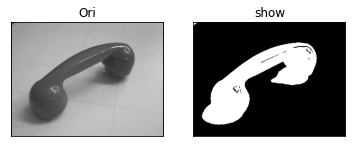

In [21]:
phone_ori = readGRAY('data/01_phone.png')
phone_bin = ohta(phone_ori, 127)

show(phone_ori, phone_bin)

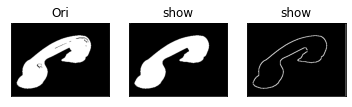

In [22]:
kernel = np.ones((5, 5), dtype=np.uint8)
phone_close = cv2.morphologyEx(phone_bin, cv2.MORPH_CLOSE, kernel)
phone_edge =  phone_bin - cv2.erode(phone_close, kernel)
show(phone_bin, phone_close, phone_edge)

In [23]:
def draw_edge(pic):
    pic_ori = pic.copy()
    pic_gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    pic_bin =  ohta(pic_gray, 127)
    kernel = np.ones((5, 5), dtype=np.uint8)
    pic_close = cv2.morphologyEx(
        pic_bin,
        cv2.MORPH_CLOSE,
        kernel
    )
    pic_edge = pic_bin - cv2.erode(pic_close, kernel)

    row, col, dim= pic_ori.shape
    for i in range(row):
        for j in range(col):
            if pic_edge[i][j] == 255:
                pic_ori[i][j] = [255, 0, 0]
    # 绘制图像
    while True:
        plt.subplot(231)
        plt.imshow(pic)
        plt.title("Original")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(232)
        plt.imshow(pic_bin, cmap='gray')
        plt.title("Binary")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(233)
        plt.imshow(pic_close, cmap='gray')
        plt.title("Close")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(234)
        plt.imshow(pic_edge, cmap='gray')
        plt.title("Edge")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(235)
        plt.imshow(pic_ori, cmap='gray')
        plt.title("Drawed")
        plt.xticks([])
        plt.yticks([])
        break

    plt.savefig('Drawed.png', dpi=500)

This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success


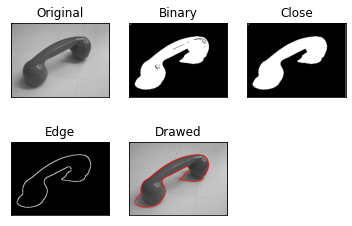

In [24]:
test = readRGB('data/01_phone.png')
draw_edge(test)

In [25]:
def self_dilation(pic, win_size):
    # 传入一个 RGB 彩图
    pic_ori = pic.copy()    # 复制一个彩色的原图
    pic_gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    pic_bin =  ohta(pic_gray, 127)
    if win_size % 2 == 0:
        win_size += 1

    kernel = np.zeros((win_size, win_size), dtype=np.uint8)

    for count in range(win_size):
        kernel[count][int(win_size / 2)] = 1
        kernel[int(win_size / 2)][count] = 1

    # 测试 模式 是否通过
    # plt.imshow(kernel)
    # print(kernel)

    row, col = pic_bin.shape
    img = np.zeros((row, col), np.uint8)
    step = int(win_size / 2)
    for i in range(step, row - step):
        for j in range(step, col - step):
            # todo
            for n in range(win_size):
                for m in range(win_size):
                    if kernel[n][m] == 1 and pic_bin[i - step + n][j - step + m] != 0:
                        img[i][j] = 255
    # show(pic_ori, pic_bin, img)
    return img

This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success


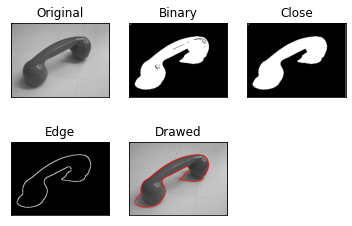

In [26]:
test = readRGB('data/01_phone.png')
draw_edge(test)

In [27]:
def self_erosion(pic, win_size):
    # 传入一个 RGB 彩图
    pic_ori = pic.copy()    # 复制一个彩色的原图
    pic_gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    pic_bin =  ohta(pic_gray, 127)
    if win_size % 2 == 0:
        win_size += 1

    kernel = np.zeros((win_size, win_size), dtype=np.uint8)

    for count in range(win_size):
        kernel[count][int(win_size / 2)] = 1
        kernel[int(win_size / 2)][count] = 1

    # 测试 模式 是否通过
    # plt.imshow(kernel)
    # print(kernel)

    row, col = pic_bin.shape
    img = np.zeros((row, col), np.uint8)
    step = int(win_size / 2)
    for i in range(step, row - step):
        for j in range(step, col - step):
            # todo
            count = 0
            for n in range(win_size):
                for m in range(win_size):

                    if kernel[n][m] == 1 and pic_bin[i - step + n][j - step + m] == 255:
                        count += 1
            if count == win_size * 2 - 1:
                img[i][j] = 255
            else:
                img[i][j] = 0
    # show(pic_ori, pic_bin, img)
    return img

This is  0  times iteration. T =  128
[FINISH]  ohta() success
This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success
This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success


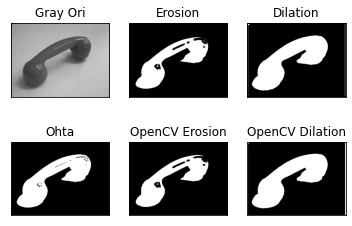

In [29]:
# 绘制 OpenCV 与 我的函数的 膨胀、腐蚀 的对比
while True:
    ori = readRGB('data/01_phone.png')
    gray = cv2.cvtColor(ori, cv2.COLOR_BGR2GRAY)
    bin = ohta(gray, 128)

    plt.subplot(231)
    plt.imshow(ori, cmap="gray")
    plt.title("Gray Ori")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(232)
    erosion = self_erosion(ori, 7)
    plt.imshow(erosion, cmap="gray")
    plt.title("Erosion")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(233)
    dilation = self_dilation(ori, 7)
    plt.imshow(dilation, cmap="gray")
    plt.title("Dilation")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(235)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    off_err = cv2.erode(bin, kernel)
    plt.imshow(off_err, cmap="gray")
    plt.title("OpenCV Erosion")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(236)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    off_di = cv2.dilate(bin, kernel)
    plt.imshow(off_di, cmap="gray")
    plt.title("OpenCV Dilation")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(234)
    plt.imshow(bin, cmap="gray")
    plt.title("Ohta")
    plt.xticks([])
    plt.yticks([])

    plt.savefig("Compare.png", dpi=500)
    break

In [30]:
ori = readRGB('data/01_phone.png')

def close_self(pic):
    row, col, dim = pic.shape
    img = np.zeros((row, col), np.uint8)
    img = self_dilation(ori, 7)
    img = self_erosion(img, 7)
    return img

close = close_self(ori)
show(close)

This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[FINISH]  ohta() success


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [33]:
print(cv2.__version__)

4.5.5
